In [1]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

from PIL import Image, ImageDraw
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPool2D, BatchNormalization, Dropout

print('Check if we are using TensorFlow 2.4')
print('Using TensorFlow version', tf.__version__)
print(tf.config.list_physical_devices('GPU'))

np.random.seed(42)

Check if we are using TensorFlow 2.4
Using TensorFlow version 2.10.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Process Objects and Textures

(112, 96, 4)


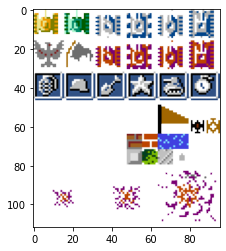

In [2]:
sprites = plt.imread('sprites.gif')
print(sprites.shape)
plt.imshow(sprites)

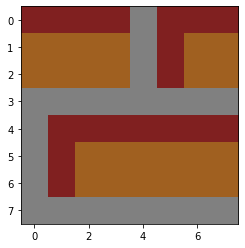

In [3]:
bs = 8
brick = sprites[bs*8:bs*9,bs*6:bs*7]
plt.imshow(brick)

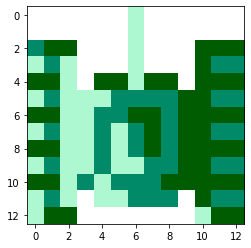

In [4]:
tank = sprites[:bs*2-3,bs*2:bs*4-3]
plt.imshow(tank)

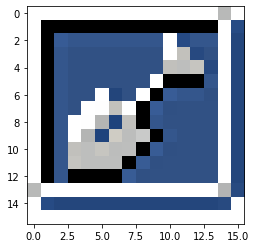

In [5]:
objects = {
    'tanks': [sprites[:bs*2-3, bs*2*i:bs*2*i+bs*2-3] for i in range(2)],
    'enemies': [sprites[:bs*2-1,bs*2*i:bs*2*i+bs*2-3] for i in range(2,6)],
    'boosted_enemies': [sprites[bs*2:bs*4-1,bs*2*i:bs*2*i+bs*2-3] for i in range(2,6)],
    'base': [sprites[bs*2:bs*4-2,bs*2*i:bs*2*i+bs*2] for i in range(2)],
    'bonuses': [sprites[bs*4:bs*6,bs*2*i:bs*2*i+bs*2] for i in range(6)],
}
textures = {
    'brick': sprites[bs*8:bs*9,bs*6:bs*7],
    'water': sprites[bs*8:bs*9,bs*8:bs*9],
    'steel': sprites[bs*9:bs*10,bs*6:bs*7],
    'bush': sprites[bs*9:bs*10,bs*7:bs*8],
    'ice': sprites[bs*9:bs*10,bs*8:bs*9],
}
other = {
    'bullet': [],
    'explodions': [],
    'effects':[],
}

plt.imshow(objects['bonuses'][2])
#objects['bonuses'][2]

### Map Generation

In [6]:
n_maps = 35
ms = 128
maps = np.empty((n_maps,26), dtype='<U26')

for i in range(n_maps):
    with open(f'levels/{i+1}', "r") as f:
        data = f.read().split("\n")
        maps[i, :] = np.array(data)

print(maps.shape)
maps[0]

(35, 26)


array(['..........................', '..........................',
       '..##..##..##..##..##..##..', '..##..##..##..##..##..##..',
       '..##..##..##..##..##..##..', '..##..##..##..##..##..##..',
       '..##..##..##@@##..##..##..', '..##..##..##@@##..##..##..',
       '..##..##..##..##..##..##..', '..##..##..........##..##..',
       '..##..##..........##..##..', '..........##..##..........',
       '..........##..##..........', '##..####..........####..##',
       '@@..####..........####..@@', '..........##..##..........',
       '..........######..........', '..##..##..######..##..##..',
       '..##..##..##..##..##..##..', '..##..##..##..##..##..##..',
       '..##..##..##..##..##..##..', '..##..##..........##..##..',
       '..##..##..........##..##..', '..##..##...####...##..##..',
       '...........#..#...........', '...........#..#...........'],
      dtype='<U26')

In [7]:
def build_city():
    data = maps[np.random.randint(n_maps)]
    
    #city = np.zeros((26*bs, 26*bs, 4)).astype('uint8')
    city = np.zeros((ms, ms, 4)).astype('uint8')
    city[:,:,3]=255
    
    #textures
    for i, row in enumerate(data):
        for j, c in enumerate(row):
            if c == '#':
                tx = textures['brick'].copy()
            elif c == '@':
                tx = textures['steel'].copy()
            elif c == '%':
                tx = textures['bush'].copy()
            elif c == '~':
                tx = textures['water'].copy()
            elif c == '-':
                tx = textures['ice'].copy()
            else:
                continue

            if bs*(i+1) > ms or bs*(j+1) > ms:
                break
            
            city[bs*i:bs*(i+1), bs*j:bs*(j+1), :] = tx
    
    #tank
    class_id = np.random.randint(2)
    
    c1 = np.random.randint(ms-15)
    c2 = np.random.randint(ms-15)

    if class_id == 0:    
        city[c1:c1+13, c2:c2+13, :] = objects['tanks'][0].copy()
    else:
        city[c1:c1+15, c2:c2+13, :] = objects['enemies'][3].copy()
    
    return city[:,:,:3], class_id, (c1/ms, c2/ms)

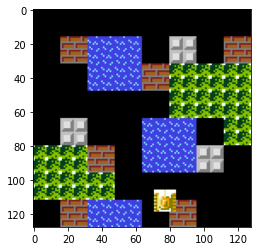

In [8]:
city, class_id, tank_coords = build_city()
        
plt.imshow(city)

$208 \times 208$

In [9]:
def plot_bounding_box(image, gt_coords, pred_coords=[], norm=False):
    row, col = gt_coords
    
    if norm:
        image *= 255.
        image = image.astype('uint8')
        
    image = Image.fromarray(image)
    draw = ImageDraw.Draw(image)
    
    
    row *= ms
    col *= ms
    draw.rectangle((col-3, row-3, col + 15, row + 15), outline='#4CFF52', width=3) #4CFF52
    
    
    if len(pred_coords) == 2:
        row, col = pred_coords
        row *= ms
        col *= ms
        draw.rectangle((col-3, row-3, col + 15, row + 15), outline='#FF229A', width=3) #FF229A
        
    return image

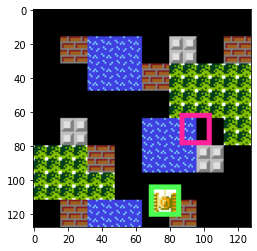

In [10]:
image = plot_bounding_box(city, tank_coords, (0.5, 0.7))
plt.imshow(image)

In [11]:
def data_generator(batch_size=16):
    while True:
        x_batch = np.zeros((batch_size, ms, ms, 3))
        y_batch = np.zeros((batch_size, 2))
        bbox_batch = np.zeros((batch_size, 2))
        
        for i in range(0, batch_size):
            image, class_id, coords = build_city()

            x_batch[i] = image / 255.
            y_batch[i, class_id] = 1.
            bbox_batch[i] = np.array(coords)
        
        yield {'image': x_batch}, {'class_out': y_batch, 'box_out': bbox_batch} # inputs, outputs

Text(0.5, 1.0, '0')

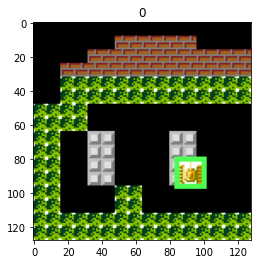

In [12]:
example, label = next(data_generator(1))
image = example['image'][0]
class_id = np.argmax(label['class_out'][0])
coords = label['box_out'][0]

image = plot_bounding_box(image, coords, norm=True)
plt.imshow(image)
plt.title(class_id)

In [13]:
input_ = Input(shape=(ms, ms, 3), name='image')

x = input_

for i in range(0, 5):
    #n_filters = 2**(1 + i)
    n_filters = 2**(2 + i)
    x = Conv2D(n_filters, 3, activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(2)(x)
    
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
    
class_out = Dense(2, activation='softmax', name='class_out')(x)
box_out = Dense(2, name='box_out')(x)

model = tf.keras.models.Model(input_, [class_out, box_out])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 126, 126, 4)  112         ['image[0][0]']                  
                                                                                                  
 batch_normalization (BatchNorm  (None, 126, 126, 4)  16         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

### Metric: IoU

In [14]:
class IoU(tf.keras.metrics.Metric):
    def __init__(self, **kwargs):
        super(IoU, self).__init__(**kwargs)
        
        self.iou = self.add_weight(name='iou', initializer='zeros')
        self.total_iou = self.add_weight(name='total_iou', initializer='zeros')
        self.num_ex = self.add_weight(name='num_ex', initializer='zeros')
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        def get_box(y):
            rows, cols = y[:, 0], y[:, 1]
            rows, cols = rows * 144, cols * 144
            y1, y2 = rows, rows + 52
            x1, x2 = cols, cols + 52
            
            return x1, y1, x2, y2
            
        def get_area(x1, y1, x2, y2):
            return tf.math.abs(x2 - x1) * tf.math.abs(y2 - y1)
            
        gt_x1, gt_y1, gt_x2, gt_y2 = get_box(y_true)
        p_x1, p_y1, p_x2, p_y2 = get_box(y_pred)
        
        i_x1 = tf.maximum(gt_x1, p_x1)
        i_y1 = tf.maximum(gt_y1, p_y1)
        i_x2 = tf.minimum(gt_x2, p_x2)
        i_y2 = tf.minimum(gt_y2, p_y2)
        
        # elements with intersection
        mask = tf.cast(tf.math.logical_and(tf.math.less(i_x1, i_x2), tf.math.less(i_y1, i_y2)), tf.float32)
        
        i_area = tf.math.multiply(get_area(i_x1, i_y1, i_x2, i_y2), mask)
        
        u_area = get_area(gt_x1, gt_y1, gt_x2, gt_y2) + get_area(p_x1, p_y1, p_x2, p_y2) - i_area
        
        iou = tf.math.divide(i_area, u_area)
        
        self.num_ex.assign_add(1)
        self.total_iou.assign_add(tf.reduce_mean(iou))              # ???
        self.iou = tf.math.divide(self.total_iou, self.num_ex)
        
    def result(self):
        return self.iou
    
    def reset_state(self):
        self.iou = self.add_weight(name='iou', initializer='zeros')
        self.total_iou = self.add_weight(name='total_iou', initializer='zeros')
        self.num_ex = self.add_weight(name='num_ex', initializer='zeros')

## Task 8: Compile the Model

In [15]:
model.compile(
    loss={
        'class_out': 'categorical_crossentropy',
        'box_out': 'mse'
    },
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    metrics={
        'class_out': 'accuracy',
        'box_out': IoU(name='iou')
    },
    run_eagerly=True
)

## Task 9: Custom Callback: Model Testing

In [16]:
def test_model(model, test_datagen):
    example, label = next(test_datagen)
    x = example['image']
    y = label['class_out']
    box = label['box_out']
    
    pred_y, pred_box = model.predict(x)
    
    pred_coords = pred_box[0]
    gt_coords = box[0]
    
    pred_class = np.argmax(pred_y[0])
    gt_class = np.argmax(y[0])
    
    image = x[0]
    
    gt = 'tank' if gt_class == 0 else 'enemy'
    pred_class_name = 'tank' if pred_class == 0 else 'enemy'
    
    image = plot_bounding_box(image, gt_coords, pred_coords, norm=True)
    color = 'green' if gt == pred_class_name else 'red'
    
    plt.imshow(image)
    plt.xlabel(f'Pred: {pred_class_name}', color=color)
    plt.ylabel(f'GT: {gt}', color=color)
    plt.xticks([])
    plt.yticks([])
    

In [17]:
def test(model):
    test_datagen = data_generator(1)
    
    plt.figure(figsize=(16, 4))
    
    for i in range(0, 6):
        plt.subplot(1, 6, i + 1)
        test_model(model, test_datagen)
        
    plt.show()

1/1 [==============================] - 0s 23ms/step


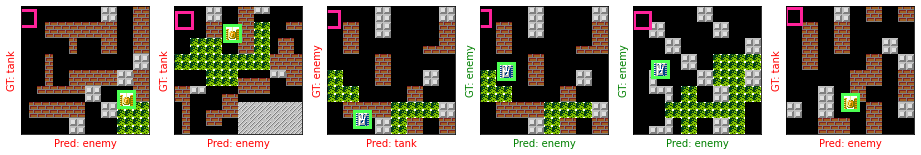

In [18]:
test(model)

In [19]:
class ShowTestImages(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        test(self.model)

## Task 10: Model Training

In [20]:
def lr_schedule(epoch, lr):
    if (epoch + 1) % 5 == 0:
        lr *= 0.2
        
    return max(lr, 3e-7)

Epoch 1/50
1/1 [==============================] - 0s 23ms/step


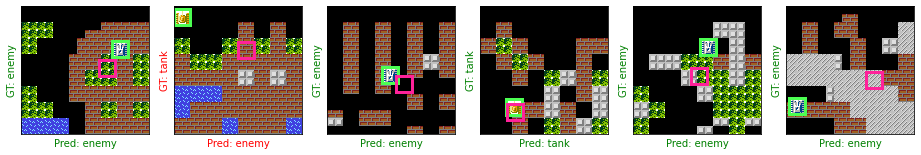

500/500 [==============================] - 34s 67ms/step - loss: 0.7611 - class_out_loss: 0.5481 - box_out_loss: 0.2130 - class_out_accuracy: 0.6641 - box_out_iou: 0.1467 - lr: 0.0100
Epoch 2/50
1/1 [==============================] - 0s 23ms/step


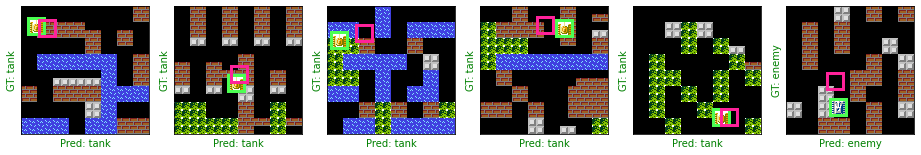

500/500 [==============================] - 27s 54ms/step - loss: 0.0468 - class_out_loss: 0.0045 - box_out_loss: 0.0423 - class_out_accuracy: 0.9990 - box_out_iou: 0.2818 - lr: 0.0100
Epoch 3/50
1/1 [==============================] - 0s 25ms/step


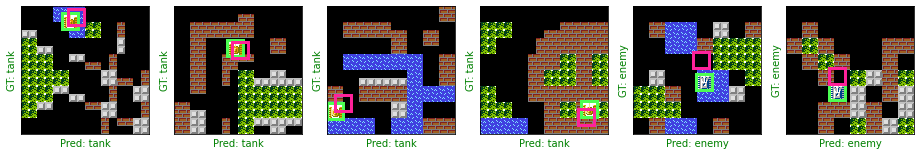

500/500 [==============================] - 27s 53ms/step - loss: 0.0348 - class_out_loss: 0.0013 - box_out_loss: 0.0335 - class_out_accuracy: 0.9998 - box_out_iou: 0.3386 - lr: 0.0100
Epoch 4/50
1/1 [==============================] - 0s 22ms/step


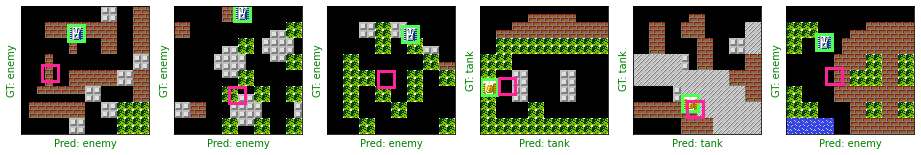

500/500 [==============================] - 27s 54ms/step - loss: 0.0227 - class_out_loss: 0.0027 - box_out_loss: 0.0200 - class_out_accuracy: 0.9991 - box_out_iou: 0.4193 - lr: 0.0100
Epoch 5/50
1/1 [==============================] - 0s 23ms/step


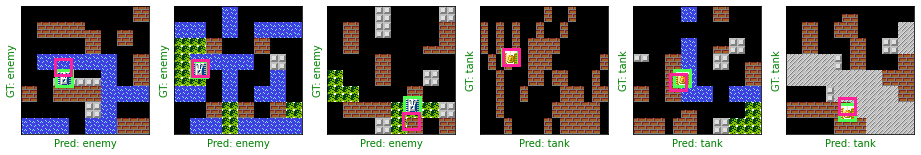

500/500 [==============================] - 28s 56ms/step - loss: 0.0053 - class_out_loss: 3.8563e-04 - box_out_loss: 0.0050 - class_out_accuracy: 0.9999 - box_out_iou: 0.6239 - lr: 0.0020
Epoch 6/50
1/1 [==============================] - 0s 34ms/step


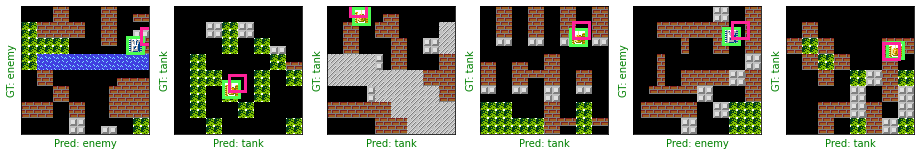

500/500 [==============================] - 28s 55ms/step - loss: 0.0196 - class_out_loss: 0.0127 - box_out_loss: 0.0069 - class_out_accuracy: 0.9971 - box_out_iou: 0.5859 - lr: 0.0020
Epoch 7/50
1/1 [==============================] - 0s 22ms/step


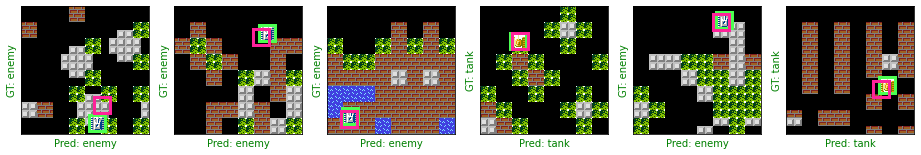

500/500 [==============================] - 35s 71ms/step - loss: 0.0035 - class_out_loss: 1.4826e-04 - box_out_loss: 0.0034 - class_out_accuracy: 1.0000 - box_out_iou: 0.6604 - lr: 0.0020
Epoch 8/50
1/1 [==============================] - 0s 27ms/step


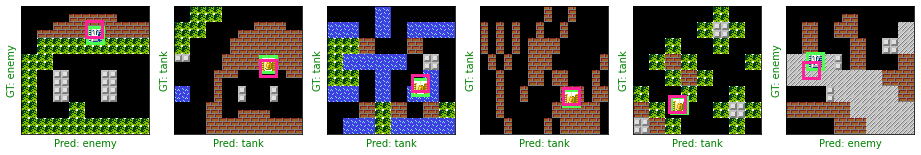

500/500 [==============================] - 28s 55ms/step - loss: 0.0044 - class_out_loss: 0.0012 - box_out_loss: 0.0032 - class_out_accuracy: 0.9999 - box_out_iou: 0.6664 - lr: 0.0020
Epoch 9/50
1/1 [==============================] - 0s 27ms/step


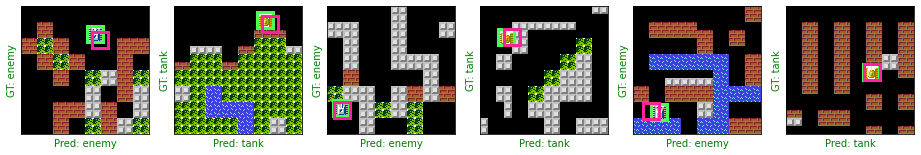

500/500 [==============================] - 26s 53ms/step - loss: 0.0023 - class_out_loss: 1.0287e-04 - box_out_loss: 0.0022 - class_out_accuracy: 1.0000 - box_out_iou: 0.7028 - lr: 0.0020
Epoch 10/50
1/1 [==============================] - 0s 31ms/step


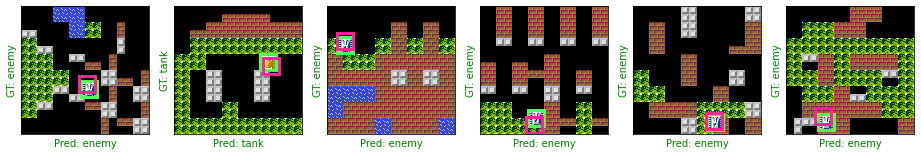

500/500 [==============================] - 33s 67ms/step - loss: 0.0017 - class_out_loss: 1.0421e-04 - box_out_loss: 0.0016 - class_out_accuracy: 1.0000 - box_out_iou: 0.7417 - lr: 4.0000e-04
Epoch 11/50
1/1 [==============================] - 0s 23ms/step


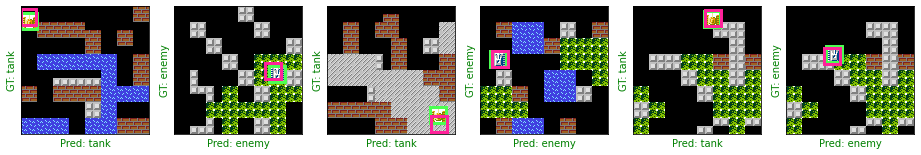

500/500 [==============================] - 30s 61ms/step - loss: 0.0019 - class_out_loss: 3.7298e-04 - box_out_loss: 0.0015 - class_out_accuracy: 0.9999 - box_out_iou: 0.7495 - lr: 4.0000e-04
Epoch 12/50
1/1 [==============================] - 0s 24ms/step


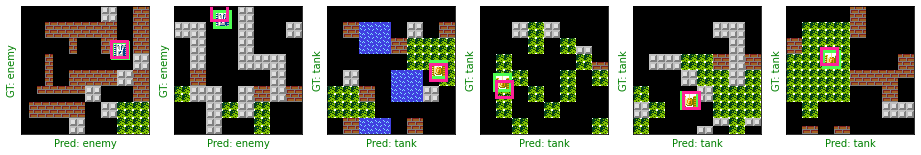

500/500 [==============================] - 28s 55ms/step - loss: 0.0017 - class_out_loss: 2.3391e-04 - box_out_loss: 0.0015 - class_out_accuracy: 0.9999 - box_out_iou: 0.7528 - lr: 4.0000e-04
Epoch 13/50
1/1 [==============================] - 0s 30ms/step


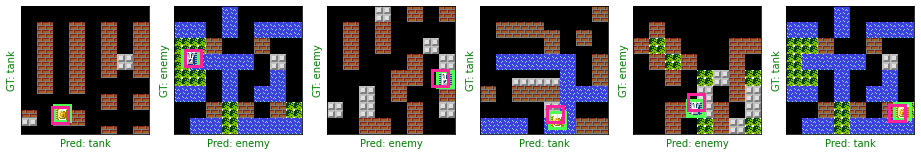

500/500 [==============================] - 31s 63ms/step - loss: 0.0015 - class_out_loss: 1.1874e-04 - box_out_loss: 0.0013 - class_out_accuracy: 1.0000 - box_out_iou: 0.7590 - lr: 4.0000e-04
Epoch 14/50
1/1 [==============================] - 0s 26ms/step


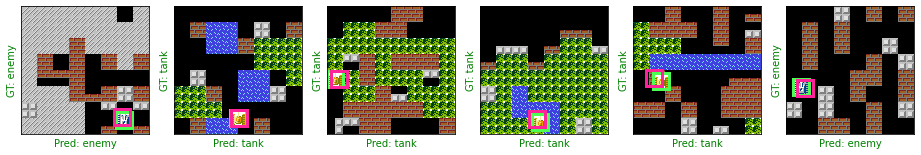

500/500 [==============================] - 34s 68ms/step - loss: 0.0012 - class_out_loss: 3.5738e-05 - box_out_loss: 0.0012 - class_out_accuracy: 1.0000 - box_out_iou: 0.7656 - lr: 4.0000e-04
Epoch 15/50
1/1 [==============================] - 0s 26ms/step


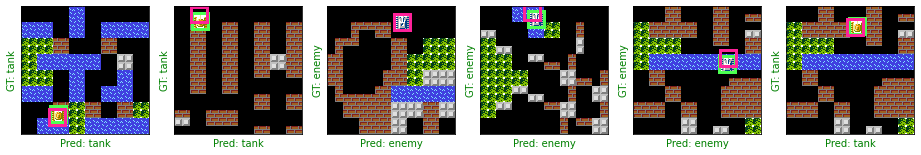

500/500 [==============================] - 28s 55ms/step - loss: 0.0010 - class_out_loss: 2.5311e-05 - box_out_loss: 9.9629e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.7848 - lr: 8.0000e-05
Epoch 16/50
1/1 [==============================] - 0s 27ms/step


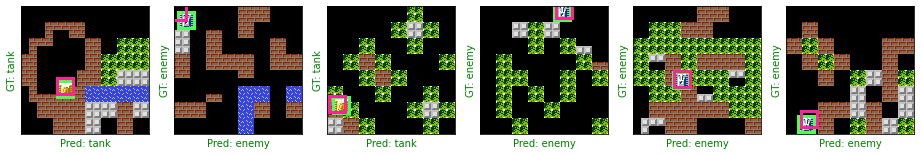

500/500 [==============================] - 28s 56ms/step - loss: 0.0011 - class_out_loss: 3.8783e-05 - box_out_loss: 0.0010 - class_out_accuracy: 1.0000 - box_out_iou: 0.7829 - lr: 8.0000e-05
Epoch 17/50
1/1 [==============================] - 0s 31ms/step


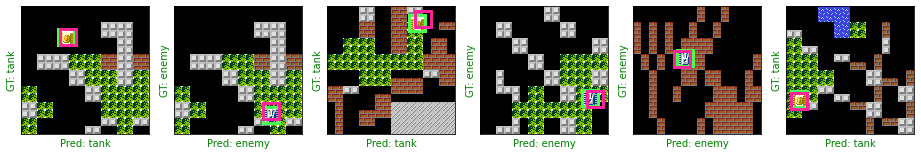

500/500 [==============================] - 36s 72ms/step - loss: 9.6341e-04 - class_out_loss: 3.3787e-05 - box_out_loss: 9.2963e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.7895 - lr: 8.0000e-05
Epoch 18/50
1/1 [==============================] - 0s 23ms/step


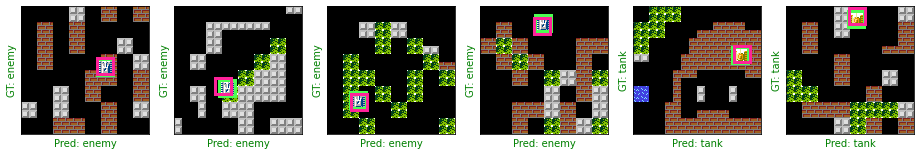

500/500 [==============================] - 29s 57ms/step - loss: 9.5879e-04 - class_out_loss: 2.5763e-05 - box_out_loss: 9.3303e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.7916 - lr: 8.0000e-05
Epoch 19/50
1/1 [==============================] - 0s 24ms/step


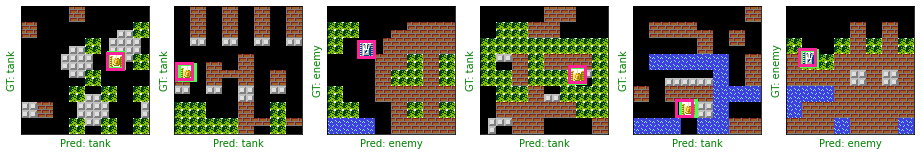

500/500 [==============================] - 27s 54ms/step - loss: 0.0015 - class_out_loss: 5.1789e-04 - box_out_loss: 9.3403e-04 - class_out_accuracy: 0.9999 - box_out_iou: 0.7914 - lr: 8.0000e-05
Epoch 20/50
1/1 [==============================] - 0s 28ms/step


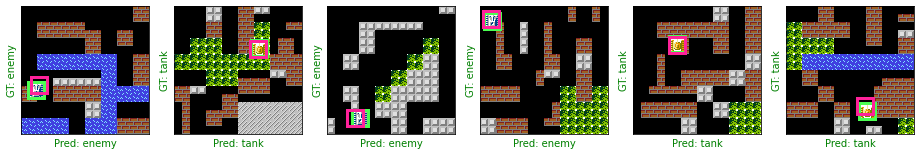

500/500 [==============================] - 33s 66ms/step - loss: 9.0790e-04 - class_out_loss: 2.6857e-05 - box_out_loss: 8.8104e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.7968 - lr: 1.6000e-05
Epoch 21/50
1/1 [==============================] - 0s 24ms/step


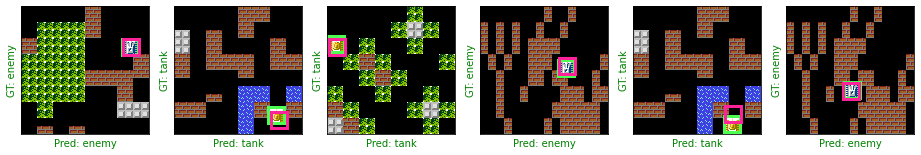

500/500 [==============================] - 32s 63ms/step - loss: 8.7046e-04 - class_out_loss: 1.7922e-05 - box_out_loss: 8.5254e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.7991 - lr: 1.6000e-05
Epoch 22/50
1/1 [==============================] - 0s 30ms/step


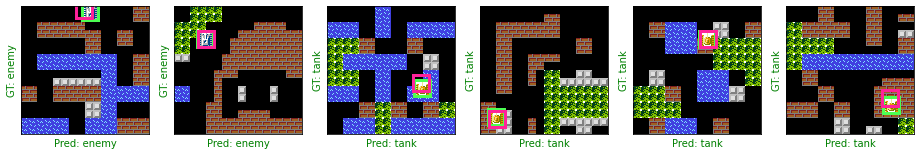

500/500 [==============================] - 27s 54ms/step - loss: 9.3641e-04 - class_out_loss: 1.2098e-04 - box_out_loss: 8.1543e-04 - class_out_accuracy: 0.9999 - box_out_iou: 0.8016 - lr: 1.6000e-05
Epoch 23/50
1/1 [==============================] - 0s 30ms/step


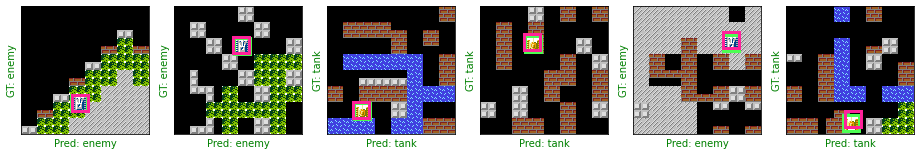

500/500 [==============================] - 33s 66ms/step - loss: 8.3700e-04 - class_out_loss: 2.0542e-05 - box_out_loss: 8.1646e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.8003 - lr: 1.6000e-05
Epoch 24/50
1/1 [==============================] - 0s 21ms/step


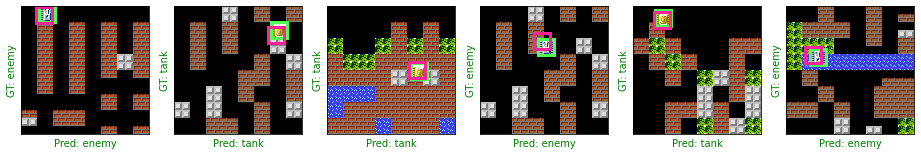

500/500 [==============================] - 30s 60ms/step - loss: 8.3946e-04 - class_out_loss: 2.2206e-05 - box_out_loss: 8.1725e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.8021 - lr: 1.6000e-05
Epoch 25/50
1/1 [==============================] - 0s 26ms/step


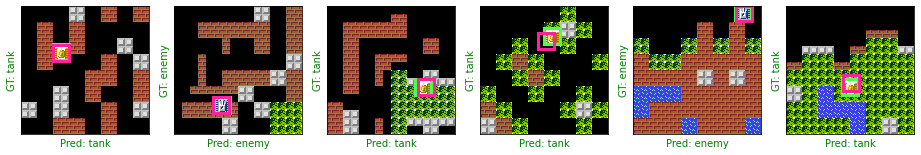

500/500 [==============================] - 27s 54ms/step - loss: 8.7683e-04 - class_out_loss: 3.1882e-05 - box_out_loss: 8.4495e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.8001 - lr: 3.2000e-06
Epoch 26/50
1/1 [==============================] - 0s 30ms/step


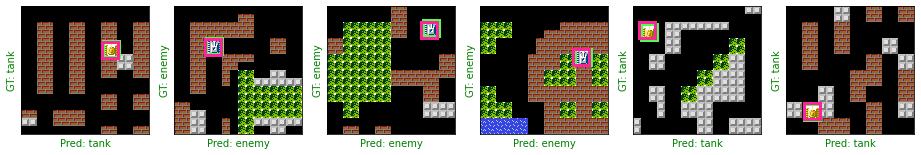

500/500 [==============================] - 32s 64ms/step - loss: 8.4075e-04 - class_out_loss: 2.7016e-05 - box_out_loss: 8.1373e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.8013 - lr: 3.2000e-06
Epoch 27/50
1/1 [==============================] - 0s 27ms/step


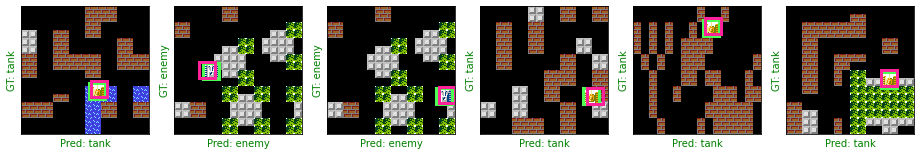

500/500 [==============================] - 31s 63ms/step - loss: 8.1463e-04 - class_out_loss: 2.1033e-05 - box_out_loss: 7.9360e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.8005 - lr: 3.2000e-06


In [21]:
_ = model.fit(
    data_generator(),
    epochs=50,
    steps_per_epoch=500,
    callbacks=[
        ShowTestImages(),
        tf.keras.callbacks.EarlyStopping(monitor='box_out_iou', patience=3, mode='max'),
        tf.keras.callbacks.LearningRateScheduler(lr_schedule)
    ]
)

In [31]:
model.save('bc128_80.h5')

In [32]:
model_1 = tf.keras.models.load_model('bc128_80.h5')
model_1.summary()

TypeError: __init__() missing 2 required positional arguments: 'num_classes' and 'target_class_ids'